In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pylab as pl

In [3]:
%matplotlib inline

In [4]:
path = r'C:\Users\slave\OneDrive\Documents\Spotify'
df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'data_analyzed.csv'))

In [5]:
df.head()

Unnamed: 0  Position                  Track Name         Artist  Streams  \
0           0         1  Reggaetón Lento (Bailemos)           CNCO    19272   
1           1         2                    Chantaje        Shakira    19270   
2           2         3   Otra Vez (feat. J Balvin)  Zion & Lennox    15761   
3           3         4                Vente Pa' Ca   Ricky Martin    14954   
4           4         5                      Safari       J Balvin    14269   

         Date Region  Missing Artist  Missing Track Name  Country  Week  
0  2017-01-01     ec           False               False  Ecuador     1  
1  2017-01-01     ec           False               False  Ecuador     1  
2  2017-01-01     ec           False               False  Ecuador     1  
3  2017-01-01     ec           False               False  Ecuador     1  
4  2017-01-01     ec           False               False  Ecuador     1

In [6]:
# deleting non-numerical columns in order to run k-means algorithm

df_2 = df.drop(columns=['Unnamed: 0', 'Track Name','Artist','Date','Region','Missing Artist','Missing Track Name','Country'])

In [7]:
df_2.head()

Position  Streams  Week
0         1    19272     1
1         2    19270     1
2         3    15761     1
3         4    14954     1
4         5    14269     1

# Standardizing the Data

In [8]:
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(df_2), columns=df_2.columns, index=df_2.index)

In [9]:
pca = PCA()
pca.fit(df_std)

PCA()

In [10]:
pca.explained_variance_ratio_

array([0.37815277, 0.33381532, 0.28803191])

Text(0, 0.5, 'Cumulative Explained Variance')

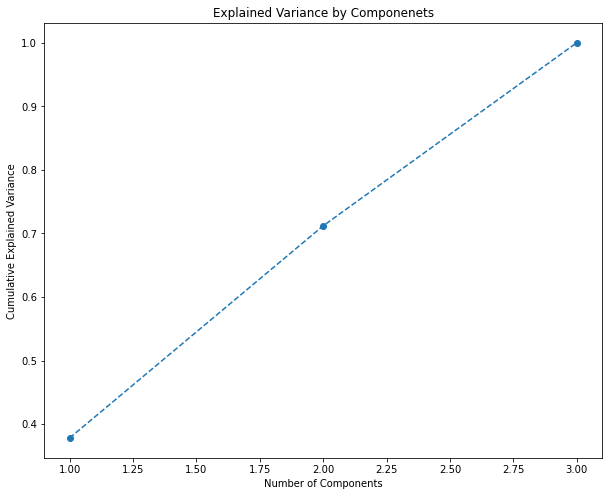

In [11]:
plt.figure(figsize = (10,8))
plt.plot(range(1,4), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Componenets')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [12]:
# choosing 3 components
pca = PCA(n_components = 3)

In [13]:
# fitting the model
pca.fit(df_std)

PCA(n_components=3)

In [14]:
pca.transform(df_std)

array([[ 1.14701874, -1.78646597, -1.05874125],
       [ 1.13466943, -1.78575543, -1.04647146],
       [ 1.11010043, -1.78725848, -1.04635832],
       ...,
       [-1.55400298,  1.74144433,  0.8923346 ],
       [-1.56638016,  1.74214983,  0.90457667],
       [-1.57877129,  1.7428528 ,  0.91680487]])

In [15]:
scores_pca = pca.transform(df_std)

In [16]:
# k-means clustering
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

In [17]:
#plotting
plt.plot(range(1,21), wcss, marker = 'o', linestyle = '--')
plt.title('K-Means with PCA Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [18]:
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [19]:
# fitting the data
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

In [20]:
# creating new dataframe
df_kmeans = pd.concat([df_std.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
# adding pca kmeans
df_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [21]:
df_kmeans.head()

Position   Streams     Week  Component 1  Component 2  Component 3  \
0 -1.631552 -0.161641 -1.71463     1.147019    -1.786466    -1.058741   
1 -1.614129 -0.161651 -1.71463     1.134669    -1.785755    -1.046471   
2 -1.596706 -0.179039 -1.71463     1.110100    -1.787258    -1.046358   
3 -1.579283 -0.183038 -1.71463     1.094946    -1.787056    -1.036879   
4 -1.561860 -0.186433 -1.71463     1.080217    -1.786777    -1.026977   

   Segment K-means PCA  
0                    3  
1                    3  
2                    3  
3                    3  
4                    3

In [22]:
# adding names of segments to labels
df_kmeans['Segment'] = df_kmeans['Segment K-means PCA'].map({0: 'first',
                                                            1: 'second',
                                                            2: 'third',
                                                            3: 'fourth'})

In [23]:
# plotting data by PCA components. Y-axis is first component, X-axis is second component
x_axis = df_kmeans['Component 2']
y_axis = df_kmeans['Component 1']
plt.figure(figsize = (10,8))
plt.title('Clusters by PCA Components')
sns.scatterplot(x = 'Component 2', y = 'Component 1', data = df_kmeans, hue = df_kmeans['Segment'], palette = ['g', 'r', 'c','m'])
plt.show()

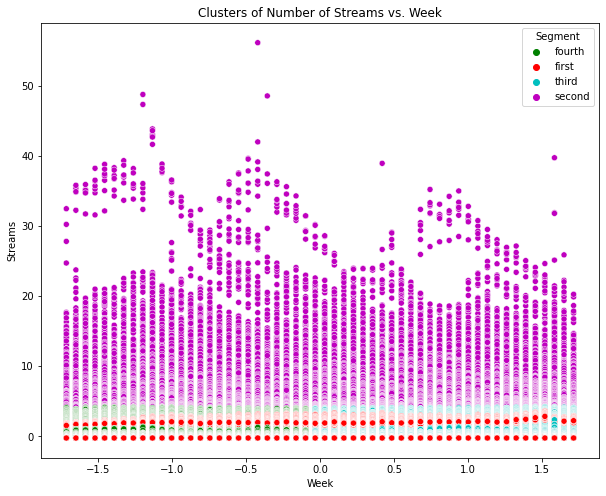

In [24]:
# plotting number of streams per week
plt.figure(figsize = (10,8))
plt.title('Clusters of Number of Streams vs. Week')
sns.scatterplot(x = 'Week', y = 'Streams', data = df_kmeans, hue = df_kmeans['Segment'], palette = ['g', 'r', 'c','m'])
plt.show()

The fourth cluster (green) isn't relevant in later weeks and is overtaken by the third cluster (blue). This means that songs that were in the top 200 at the beginning of the year didn't stay there by the end of the year. More analysis would have to be performed.

In [28]:
df_kmeans.loc[df_kmeans['Segment K-means PCA'] == 3, 'cluster'] = 'green'
df_kmeans.loc[df_kmeans['Segment K-means PCA'] == 2, 'cluster'] = 'blue'
df_kmeans.loc[df_kmeans['Segment K-means PCA'] == 1, 'cluster'] = 'purple'
df_kmeans.loc[df_kmeans['Segment K-means PCA'] == 0, 'cluster'] = 'red'

In [31]:
df_kmeans.groupby('cluster').agg({'Position':['mean', 'median'], 
                         'Streams':['mean', 'median'], 
                         'Week':['mean', 'median']})

Position             Streams                Week          
             mean    median      mean    median      mean    median
cluster                                                            
blue    -0.627688 -0.655868 -0.041781 -0.198786  0.886462  0.938253
green   -0.562812 -0.603600 -0.060221 -0.207944 -0.959783 -1.002881
purple  -1.019194 -1.056595  8.049572  6.697076  0.039165  0.032390
red      1.112205  1.138693 -0.121782 -0.225723  0.069810  0.097095

This makes sense as the lower the position, the more number of streams (because lower number represents the more popular songs). And it confirms the above that songs that started in the top 200 at the beginning of the year didn't last the entire year there looking at the 'Week' column.